# Towards paper-01: 

**Making the analysis shareable and presentable**

Date: 04/18/2023

**Notes**: 

* Hoping this can serve as an basis for how the future ratio analysis can be done.  
* First sanity checking the ay I'm normalizing as this is huge.

## **Imports**

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
import sys
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import seaborn as sns
from datetime import datetime
import numpy as np
import uproot4
from lmfit import minimize, Parameters, fit_report
import lmfit
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from scipy import stats

# Jupyter Lab imports.
import ipywidgets as widgets
from ipywidgets import interact, interact_manual, fixed

# Path to local imports.
sys.path.append("/home/drew/He6CRES/rocks_analysis_pipeline/")
from results import ExperimentResults
from rocks_utility import he6cres_db_query

# Path to local imports.
sys.path.append("/home/drew/He6CRES/he6-cres-spec-sims/")

# Local imports.
import he6_cres_spec_sims.spec_tools.spec_calc.spec_calc as sc
import he6_cres_spec_sims.experiment as exp
import he6_cres_spec_sims.spec_tools.beta_source.beta_spectrum as bs

# Local imports for plotting ratios and such. 
import analysis_functions.ratio_experiment as re
import analysis_functions.ratio_prediction as rp
import analysis_functions.quality_control_methods as qc
import analysis_functions.plotting_methods as pm
import analysis_functions.event_clustering as clust

import mc_functions.simple_mc as mc
import mc_functions.wall_effect as we
import mc_functions.energy_domain as ed
import mc_functions.from_below as fb

## Purpose of Document: 

* Sharing my (Drew) most recent analysis work and current pipeline. 

## Notes: 

* I am only showing the results of the SNR = 9 test for computational ease and because they all seem to trend together. The others can be added into this analysis by uncommenting them in the loading procedure below

## Ideas for Future Work: 

* Say you fit to the max prob of being observed at each cut and see if they are consistent? 
* There is a roll-off in detected tracks with frequency. Why would this be? Think about this and try to incorporate it into the new MC. 
* Just take the ratio in regions with low event rates? How does that look?

## **Step 0: Grab the results from rocks**

### Load Ne19 data

* Not grabbing root files for now. Will do this as a diagnostic if necessary. 

In [3]:
local_dir = "/media/drew/T7 Shield/rocks_analysis/saved_experiments"
include_root_files = False
max_root_files_to_grab = 0
rebuild_experiment_dir = False

snrs = [9]
aids = [26]
# snrs = [8,9,10]
# aids = [25,26,27]
n_files = 100
experiment_names = [f"ne_snr{snr}_fn{n_files}" for snr in snrs]
print(experiment_names)

ne_snr_results = [ ExperimentResults(local_dir = local_dir, 
                                     experiment_name = experiment_name, 
                                     analysis_id = aid, 
                                     include_root_files = include_root_files,
                                     max_root_files_to_grab = max_root_files_to_grab,
                                     rebuild_experiment_dir=rebuild_experiment_dir,
                                    )
                  for (experiment_name, aid) in zip(experiment_names, aids)]


['ne_snr9_fn100']
Keeping existing experiment directory.




### Load He6 data

* Not grabbing root files for now. Will do this as a diagnostic if necessary. 

In [4]:
local_dir = "/media/drew/T7 Shield/rocks_analysis/saved_experiments"
include_root_files = False
max_root_files_to_grab = 0
rebuild_experiment_dir = False


snrs = [9]
aids = [22]
# snrs = [8,9,10]
# aids = [21,22,23]
n_files = 100
experiment_names = [f"he_snr{snr}_fn{n_files}" for snr in snrs]
print(experiment_names)

he_snr_results = [ ExperimentResults(local_dir = local_dir, 
                                     experiment_name = experiment_name, 
                                     analysis_id = aid, 
                                     include_root_files = include_root_files,
                                     max_root_files_to_grab = max_root_files_to_grab,
                                     rebuild_experiment_dir=rebuild_experiment_dir,
                                    )
                  for (experiment_name, aid) in zip(experiment_names, aids)]


['he_snr9_fn100']
Keeping existing experiment directory.




### Build all he and ne results into one dictionary

In [5]:
# Aggregate the results.
snr_cuts = np.array([9])
snr_study = { "ne": dict(zip(snr_cuts,ne_snr_results)),
              "he": dict(zip(snr_cuts,he_snr_results))}

## **Step 1: Another Layer of DBSCAN Clustering.** 

* I need to first apply the cuts that I found were most appropriate. 

### Define the clust_params. Based on testing each field separately. 

**Notes**: 
* I tried to come up with a more quantitative way to decide these epsilons but failed (see below). Ultimately I just looked at the event reconstruction using the quality control tools below. More work could go here, but the finding that there are "too many" Ne counts at low fields or too many He counts at high fields remains regardless of the chosen epsilons. To a limit; if you crank them to .5 or something you break everything. 

#### Epsilon Ideas: 

**Idea**: How to decide this epsilon?

1. What if we scale the epsilon with 1/slope?
    * This didn't work well. Either at low or high fields depending. I also tried scaling it with 1/slope^2. 

In [7]:
features = [ "EventTimeIntc", "EventStartTime"]
set_fields = np.arange(.75,3.5,.25)
epss = np.array([.5,.2,.07,.04,.01,.01, .005, .005, .002, .0001, .000001])# Verified this is good. 3/30/23 
epss = np.array([.5,.2,.002,.01,.01,.002, .002, .002, .002, .0001, .000001])

# Drew's epss were garbage for the most part.. the below is from Heather's more quantitative approach.
epss = np.array([0.08, 0.08, 0.02, 0.01, 0.003, 0.0015, 0.0008, 0.0004, 0.00015, 0.0001, 0.00008])#from Heather

# The below should account for sidebands based on Heather's stuff. We'll see. 
# epss =np.array([0.08, 0.08, 0.02, 0.01, 0.006, 0.004, 0.0025, 0.002, 0.00125, 0.001, 0.0008]) 
clust_params = {}

for (set_field, eps) in zip(set_fields, epss): 
    
    clust_params.update({set_field : {"eps":eps}})
    
    if set_field < 1.5: 
        clust_params[set_field].update(  {"features":features} )
    else: 
        clust_params[set_field].update( {"features":["EventTimeIntc"]} )
        
print(clust_params)

{0.75: {'eps': 0.08, 'features': ['EventTimeIntc', 'EventStartTime']}, 1.0: {'eps': 0.08, 'features': ['EventTimeIntc', 'EventStartTime']}, 1.25: {'eps': 0.02, 'features': ['EventTimeIntc', 'EventStartTime']}, 1.5: {'eps': 0.01, 'features': ['EventTimeIntc']}, 1.75: {'eps': 0.003, 'features': ['EventTimeIntc']}, 2.0: {'eps': 0.0015, 'features': ['EventTimeIntc']}, 2.25: {'eps': 0.0008, 'features': ['EventTimeIntc']}, 2.5: {'eps': 0.0004, 'features': ['EventTimeIntc']}, 2.75: {'eps': 0.00015, 'features': ['EventTimeIntc']}, 3.0: {'eps': 0.0001, 'features': ['EventTimeIntc']}, 3.25: {'eps': 8e-05, 'features': ['EventTimeIntc']}}


### Drop bad rids, make intial cuts, then cluster. 

**Notes**: 
    * These initial cuts were chosen by looking at the quality control histograms and the reconstruction and making sensible cuts that got rid of anything unphysical. Really the only one of substance is the mTotalSNR > 40 which dealt with some artifitial tracks that were only plaguing SNR=8 for Helium data. It basically cuts no real events.  

In [8]:

# Note on 4/14/23 drew is changing the mTotal SNR to 0 (shouldn't matter a ton)
both_cuts = {
            "EventStartFreq": (0e6, 1200e6),
            "EventNBins": (0, np.inf), 
            "EventTimeLength": (0,.05),
            "EventTimeIntc": (-.5e7,np.inf),
            "EventFreqIntc": (-2e11,np.inf),
            "EventSlope": (.01e10, np.inf),
            "EventTrackCoverage": (.01, np.inf),
            "mTotalSNR": (0, np.inf),
            "mTotalNUP": (0, np.inf)
            } # This was verified to work 


In [9]:
drop_rid_list = [548, 549, 522, 495, 377]
cluster = True

for isotope in snr_study.keys(): 
    for cut in snr_cuts: 
        
        # Drop bad rids.
        snr_study[isotope][cut].events = snr_study[isotope][cut].events[~snr_study[isotope][cut].events.run_id.isin(drop_rid_list)]
        snr_study[isotope][cut].tracks = snr_study[isotope][cut].tracks[~snr_study[isotope][cut].tracks.run_id.isin(drop_rid_list)]
        snr_study[isotope][cut].root_files = snr_study[isotope][cut].root_files[~snr_study[isotope][cut].root_files.run_id.isin(drop_rid_list)]
        
        # Make initial cuts. Need to do this before clustering or we cluster good events into bad.   
        events = snr_study[isotope][cut].events
        print(f"{isotope}, {cut}.\npre cuts events: {len(events)}")

        # snr_study[isotope][cut].events = re.cut_df(events, both_cuts)
        events_cut = re.cut_df(events, both_cuts)
        snr_study[isotope][cut].events = events_cut
        print(f"\npost cuts events: {len(events_cut)}")
        # Cluster
        if cluster: 
            print(f"pre cluster events: {len(events_cut)} ")
            snr_study[isotope][cut].events = clust.cluster_and_clean_events(events_cut, 
                                                                            clust_params=clust_params,                                                             diagnostics=True)
            print(f"post clust events: {len(snr_study[isotope][cut].events)}")

ne, 9.
pre cuts events: 29201

post cuts events: 29195
pre cluster events: 29195 
Summary of clustring: 


Fractional reduction in counts from clustering: set_field
0.75    0.842697
1.00    0.665195
1.25    0.797068
1.50    0.771840
1.75    0.809956
2.00    0.843501
2.25    0.892162
2.50    0.899679
2.75    0.891725
3.00    0.892440
3.25    0.899614
Name: file_id, dtype: float64

Pre-clustering means:


,run_id,file_id,EventID,EventStartTime,EventEndTime,EventStartFreq,EventEndFreq,EventTimeLength,EventFreqLength,EventTrackCoverage,...,mTotalSNR,sTotalSNR,mMaxSNR,sMaxSNR,mTotalNUP,sTotalNUP,mTotalPower,sTotalPower,field,monitor_rate
set_field,,,,,,,,,,,,,,,,,,,,,
0.75,558.325843,44.932584,1.786517,0.415784,0.417785,5.212451e+08,5.230689e+08,0.002001,1.823761e+06,0.718398,...,55.297837,7.255216,14.259020,2.088470,49.090813,6.755090,126.546723,16.905822,0.750160,11546.093708
1.00,552.829286,47.841060,2.919058,0.503419,0.508412,6.127073e+08,6.318841e+08,0.004992,1.917684e+07,0.715575,...,58.257647,8.015001,15.334569,2.824139,51.554438,7.480735,124.273908,19.018719,1.000200,11605.964886
1.25,544.017865,50.742098,3.414567,0.501110,0.509461,5.892912e+08,6.596975e+08,0.008351,7.040625e+07,0.737651,...,60.297572,8.836385,15.994798,3.171569,53.507797,8.306002,128.488298,23.676058,1.250300,11179.438429
1.50,538.019185,49.206235,4.284687,0.505134,0.513803,5.362259e+08,6.707078e+08,0.008669,1.344819e+08,0.746715,...,61.048491,9.342152,16.294850,3.364653,54.275968,8.813973,132.099774,26.832349,1.500324,9801.021083
1.75,531.962727,49.525012,5.359490,0.493957,0.502456,5.082440e+08,7.256024e+08,0.008499,2.173585e+08,0.759016,...,62.401500,9.919541,16.817556,3.629158,55.546073,9.400892,134.005491,29.394666,1.750366,10241.237624
2.00,526.021424,50.066109,6.200367,0.494426,0.502446,4.613605e+08,7.754905e+08,0.008020,3.141300e+08,0.764715,...,63.032530,10.771352,17.034745,3.807682,56.156675,10.237539,135.383442,32.521837,2.000401,10557.636397
2.25,519.471543,49.356715,6.198702,0.490965,0.497826,4.495999e+08,8.401159e+08,0.006861,3.905161e+08,0.768391,...,63.359782,10.371616,17.179272,3.852471,56.398050,9.868305,133.662171,32.889184,2.250432,10781.992267
2.50,514.027027,48.825928,5.481219,0.491417,0.497213,4.219156e+08,8.811464e+08,0.005797,4.592308e+08,0.769349,...,61.221680,9.933645,16.419711,3.550494,54.334994,9.412156,128.020863,32.634971,2.500450,10481.408023
2.75,508.016432,49.863850,4.595951,0.503257,0.507934,4.233128e+08,9.213837e+08,0.004677,4.980709e+08,0.787563,...,58.459507,8.957195,15.456412,3.109105,51.635556,8.435627,119.821092,30.753642,2.750550,11038.667148



Pre-clustering stds:


,run_id,file_id,EventID,EventStartTime,EventEndTime,EventStartFreq,EventEndFreq,EventTimeLength,EventFreqLength,EventTrackCoverage,...,mTotalSNR,sTotalSNR,mMaxSNR,sMaxSNR,mTotalNUP,sTotalNUP,mTotalPower,sTotalPower,field,monitor_rate
set_field,,,,,,,,,,,,,,,,,,,,,
0.75,1.250230,29.440154,1.229116,0.273970,0.273736,1.831092e+08,1.830507e+08,0.001172,1.341345e+06,0.144610,...,4.280306,4.001721,1.287509,1.009236,4.032662,3.596279,28.964968,10.874692,0.000007,481.238695
1.00,1.400188,28.525080,2.103209,0.287884,0.287670,3.104467e+08,3.097073e+08,0.004988,1.875745e+07,0.111267,...,7.229889,2.973405,2.149589,1.110813,6.974101,2.729558,40.068228,8.714683,0.000005,287.920111
1.25,1.380814,28.752729,2.198847,0.293120,0.293085,3.297497e+08,3.257411e+08,0.008253,6.933274e+07,0.091272,...,8.426423,3.145556,2.607994,1.226344,8.144799,2.976235,40.508915,9.596919,0.000003,530.895139
1.50,1.402891,29.059226,2.926822,0.295243,0.295171,3.314926e+08,3.352680e+08,0.008340,1.286561e+08,0.088080,...,8.915191,3.286700,2.806639,1.346344,8.592927,3.148824,40.129622,9.794577,0.000007,314.578736
1.75,1.407637,28.696175,3.489393,0.291091,0.291228,3.379570e+08,3.424982e+08,0.008071,2.055503e+08,0.094714,...,9.436362,3.634151,3.079350,1.520088,9.101939,3.499008,40.543671,11.208695,0.000003,243.817750
2.00,1.404711,28.669384,4.011749,0.288892,0.288787,3.418372e+08,3.495816e+08,0.007061,2.756938e+08,0.098540,...,9.453309,4.171230,3.008768,1.578468,9.080564,4.050709,38.787147,12.703929,0.000006,269.542003
2.25,1.129809,28.847168,3.874557,0.290454,0.290503,3.432898e+08,3.334041e+08,0.005531,3.139244e+08,0.096246,...,8.790204,3.551657,2.897800,1.490213,8.475419,3.440310,36.866043,12.204732,0.000009,239.837466
2.50,1.404526,28.567790,3.395704,0.288650,0.288723,3.351092e+08,3.172008e+08,0.004258,3.365447e+08,0.094508,...,7.366255,3.172615,2.329969,1.289854,7.064207,3.045639,32.031967,11.845653,0.000005,245.262963
2.75,1.402447,28.693541,2.962273,0.291457,0.291415,3.212837e+08,2.900098e+08,0.003166,3.365761e+08,0.108271,...,6.092493,2.809512,1.845764,1.105921,5.791415,2.622327,27.666056,10.885752,0.000006,485.074709



Post-clustering means:


,run_id,file_id,EventID,EventStartTime,EventEndTime,EventStartFreq,EventEndFreq,EventTimeLength,EventFreqLength,EventTrackCoverage,...,mTotalSNR,sTotalSNR,mMaxSNR,sMaxSNR,mTotalNUP,sTotalNUP,mTotalPower,sTotalPower,field,monitor_rate
set_field,,,,,,,,,,,,,,,,,,,,,
0.75,558.266667,44.506667,1.506667,0.412630,0.415164,5.421021e+08,5.447066e+08,0.002534,2.604506e+06,0.720121,...,55.173806,7.313512,14.201304,2.071917,48.904708,6.792696,123.626846,16.811330,0.750159,11530.741200
1.00,552.858407,48.430310,1.952434,0.502454,0.511730,6.025924e+08,6.410491e+08,0.009276,3.845665e+07,0.717754,...,58.671627,8.085360,15.460400,2.874421,51.929449,7.555437,124.339495,19.089522,1.000200,11591.906549
1.25,544.006322,50.680460,2.728736,0.499148,0.510028,5.805870e+08,6.732729e+08,0.010880,9.268591e+07,0.743538,...,61.206182,9.004873,16.279342,3.285373,54.364947,8.487436,130.136129,24.221779,1.250300,11179.562983
1.50,538.012428,49.368842,3.230803,0.498303,0.510772,5.138786e+08,7.064361e+08,0.012470,1.925575e+08,0.752575,...,62.581658,9.639106,16.774769,3.569726,55.712023,9.134520,134.806193,27.691826,1.500324,9799.751536
1.75,531.987890,49.410839,4.360884,0.497187,0.508156,4.760308e+08,7.562369e+08,0.010970,2.802061e+08,0.764133,...,63.949157,10.290285,17.324096,3.854610,57.020149,9.788935,137.482783,30.531409,1.750366,10239.393824
2.00,526.034591,49.807934,5.210208,0.493330,0.503081,4.296434e+08,8.113980e+08,0.009751,3.817545e+08,0.768858,...,64.460218,11.214101,17.495723,4.031451,57.509969,10.692246,138.302674,33.833335,2.000402,10555.067951
2.25,519.481253,49.399273,5.530778,0.491762,0.499591,4.203382e+08,8.659658e+08,0.007829,4.456276e+08,0.772127,...,64.314606,10.584107,17.485664,3.994613,57.304171,10.095466,135.731394,33.645345,2.250432,10781.904846
2.50,514.024949,48.954939,4.926426,0.489105,0.495644,3.899772e+08,9.079972e+08,0.006538,5.180199e+08,0.773420,...,61.906418,10.090755,16.633665,3.653306,54.982459,9.581483,129.479714,33.326670,2.500450,10481.781614
2.75,508.008226,50.154327,4.085554,0.499515,0.504840,3.917351e+08,9.587468e+08,0.005325,5.670116e+08,0.791166,...,58.930491,9.059665,15.603262,3.187398,52.068634,8.548532,120.363955,31.342693,2.750550,11039.394962



Post-clustering stds:


,run_id,file_id,EventID,EventStartTime,EventEndTime,EventStartFreq,EventEndFreq,EventTimeLength,EventFreqLength,EventTrackCoverage,...,mTotalSNR,sTotalSNR,mMaxSNR,sMaxSNR,mTotalNUP,sTotalNUP,mTotalPower,sTotalPower,field,monitor_rate
set_field,,,,,,,,,,,,,,,,,,,,,
0.75,1.266335,29.089969,0.890996,0.283511,0.283289,1.822867e+08,1.815752e+08,0.001844,2.568645e+06,0.142658,...,3.859539,3.894998,1.211640,0.907034,3.629101,3.488272,28.944116,10.737898,0.000007,490.556699
1.00,1.414948,28.784563,1.169450,0.289732,0.289334,3.080422e+08,3.058726e+08,0.012054,5.488907e+07,0.098464,...,6.753271,2.657682,2.030006,1.038103,6.556056,2.446885,38.590697,7.954951,0.000005,290.970348
1.25,1.384406,28.802657,1.638026,0.294024,0.293987,3.286597e+08,3.225074e+08,0.009301,7.888892e+07,0.083584,...,8.237650,3.013747,2.586330,1.194681,7.986750,2.885010,40.047292,9.351175,0.000004,533.642408
1.50,1.405655,28.882583,1.935457,0.297243,0.297299,3.297218e+08,3.322931e+08,0.011676,1.737607e+08,0.076789,...,8.551074,3.124891,2.758366,1.299999,8.302371,3.033359,40.069113,9.548842,0.000007,315.615668
1.75,1.409013,28.792515,2.715002,0.293639,0.293605,3.321305e+08,3.395767e+08,0.008747,2.213196e+08,0.085921,...,9.147494,3.410428,3.020748,1.463845,8.857943,3.328652,40.423959,10.886622,0.000003,242.812016
2.00,1.408904,28.799857,3.219990,0.290353,0.290241,3.343525e+08,3.417336e+08,0.007189,2.800905e+08,0.089403,...,9.219805,4.012140,2.952656,1.514788,8.883895,3.933664,38.660006,12.493287,0.000006,271.003985
2.25,1.131718,28.784312,3.364926,0.291218,0.291230,3.361618e+08,3.272700e+08,0.005625,3.189094e+08,0.089145,...,8.438619,3.411715,2.829070,1.438950,8.157446,3.328293,36.169034,11.895045,0.000009,241.599807
2.50,1.403328,28.545645,2.969660,0.289055,0.289182,3.240526e+08,3.082623e+08,0.004262,3.366494e+08,0.087441,...,7.076141,3.002701,2.270895,1.235466,6.800597,2.907057,31.162467,11.460814,0.000005,244.605680
2.75,1.402386,28.616259,2.528427,0.291199,0.291223,3.116431e+08,2.683500e+08,0.003128,3.323916e+08,0.101946,...,5.885726,2.598291,1.800847,1.051668,5.604129,2.450580,26.407961,10.463988,0.000006,491.345639


post clust events: 24635
he, 9.
pre cuts events: 49614

post cuts events: 49534
pre cluster events: 49534 
Summary of clustring: 


Fractional reduction in counts from clustering: set_field
0.75    0.772059
1.00    0.809456
1.25    0.865865
1.50    0.847245
1.75    0.883385
2.00    0.911073
2.25    0.931729
2.50    0.932503
2.75    0.924615
3.00    0.912498
3.25    0.907756
Name: file_id, dtype: float64

Pre-clustering means:


,run_id,file_id,EventID,EventStartTime,EventEndTime,EventStartFreq,EventEndFreq,EventTimeLength,EventFreqLength,EventTrackCoverage,...,mTotalSNR,sTotalSNR,mMaxSNR,sMaxSNR,mTotalNUP,sTotalNUP,mTotalPower,sTotalPower,field,monitor_rate
set_field,,,,,,,,,,,,,,,,,,,,,
0.75,437.852941,49.250000,2.308824,0.553399,0.557154,5.974131e+08,5.999742e+08,0.003755,2.561164e+06,0.636630,...,55.740884,7.299711,14.627292,2.582183,48.438919,6.674160,95.655183,12.763149,0.749927,52556.289706
1.00,431.905444,50.328080,1.955587,0.504015,0.514356,6.277104e+08,6.639605e+08,0.010341,3.625009e+07,0.677775,...,60.598268,8.517193,16.219673,3.231412,52.876462,7.893554,103.472405,16.713153,0.999979,54373.407923
1.25,425.982424,50.726179,2.207216,0.493757,0.504309,5.581760e+08,6.458727e+08,0.010552,8.769672e+07,0.745662,...,64.933535,10.264814,17.608135,3.803965,57.131509,9.605535,115.061465,21.690817,1.250020,51249.191267
1.50,420.024004,50.593562,3.124386,0.497177,0.507923,5.509374e+08,7.158901e+08,0.010746,1.649527e+08,0.763471,...,66.581345,10.941992,18.208226,4.124705,58.541696,10.267493,114.575880,23.277683,1.500065,52070.678429
1.75,413.648779,47.021328,3.885105,0.506620,0.515901,5.132590e+08,7.499887e+08,0.009281,2.367297e+08,0.777541,...,67.463513,11.560492,18.673962,4.364390,59.399902,10.858155,116.417062,25.442708,1.750088,49921.651658
2.00,407.043101,48.888283,5.272727,0.490973,0.499470,4.609401e+08,7.933397e+08,0.008498,3.323996e+08,0.788736,...,68.536043,13.127954,18.958064,4.668590,60.429335,12.369934,118.365708,28.894615,2.000091,53198.423064
2.25,400.968806,49.413904,6.813369,0.492480,0.499942,4.082796e+08,8.324773e+08,0.007462,4.241978e+08,0.790917,...,68.150017,12.104450,18.952366,4.633902,60.078770,11.423066,117.930809,28.742703,2.250095,52520.057228
2.50,395.008178,49.058671,8.966121,0.500753,0.506926,3.814678e+08,8.697792e+08,0.006174,4.883114e+08,0.806919,...,65.078506,11.569323,17.858901,4.218947,57.173711,10.873227,111.617444,28.256787,2.500082,53115.156515
2.75,389.013687,49.680710,10.627032,0.494560,0.499788,3.508467e+08,9.072851e+08,0.005228,5.564385e+08,0.851793,...,61.993599,10.428801,16.769637,3.744215,54.245501,9.770633,105.305373,27.061644,2.750004,52014.254277



Pre-clustering stds:


,run_id,file_id,EventID,EventStartTime,EventEndTime,EventStartFreq,EventEndFreq,EventTimeLength,EventFreqLength,EventTrackCoverage,...,mTotalSNR,sTotalSNR,mMaxSNR,sMaxSNR,mTotalNUP,sTotalNUP,mTotalPower,sTotalPower,field,monitor_rate
set_field,,,,,,,,,,,,,,,,,,,,,
0.75,1.448010,26.971796,1.580036,0.260354,0.260160,2.805238e+08,2.802672e+08,0.003582,2.255911e+06,0.152635,...,5.960069,3.566608,1.726454,1.055028,5.455436,3.076200,26.709169,7.711661,0.000004,1151.205162
1.00,1.421176,28.492136,1.298726,0.279204,0.278822,3.264459e+08,3.224205e+08,0.008623,3.128235e+07,0.151948,...,9.656672,3.036533,2.783952,1.173304,9.155767,2.853462,35.879080,7.657773,0.000005,2338.773998
1.25,1.379300,29.278025,1.386971,0.286450,0.285867,3.362711e+08,3.368465e+08,0.008836,7.306155e+07,0.097608,...,11.336437,3.846088,3.623753,1.497553,10.800278,3.692488,38.027586,8.769754,0.000007,3562.792595
1.50,1.396921,28.980326,2.192390,0.290371,0.290423,3.458632e+08,3.460018e+08,0.008901,1.354895e+08,0.089375,...,11.966658,4.208501,3.970816,1.669883,11.472978,4.046128,38.789085,9.164701,0.000006,4122.067083
1.75,1.740415,28.498117,2.473370,0.288302,0.288559,3.551710e+08,3.532834e+08,0.008217,2.084598e+08,0.102799,...,12.547132,4.450404,4.253958,1.870261,11.958016,4.272833,38.297768,9.999865,0.000007,4137.377403
2.00,1.378594,28.595512,3.364933,0.288728,0.288694,3.496386e+08,3.543660e+08,0.007091,2.760584e+08,0.099360,...,12.284603,5.636271,4.017145,1.959116,11.680876,5.427845,36.714784,12.104587,0.000007,4893.064909
2.25,1.433343,28.573923,4.219921,0.290605,0.290436,3.412340e+08,3.467042e+08,0.005737,3.249248e+08,0.102509,...,11.391569,4.393990,3.919612,1.845235,10.838956,4.233358,34.111343,10.902778,0.000007,3366.926213
2.50,1.409547,29.279632,5.523370,0.290049,0.290018,3.320556e+08,3.335065e+08,0.004421,3.482901e+08,0.125817,...,9.870209,3.994570,3.204577,1.607210,9.363363,3.844220,29.990999,10.471949,0.000007,3920.680294
2.75,1.435091,28.914838,6.523823,0.288072,0.288079,3.127891e+08,3.112331e+08,0.003382,3.585566e+08,0.154173,...,8.099113,3.240899,2.579590,1.377687,7.640995,3.089898,25.087628,9.336009,0.000004,4059.573007



Post-clustering means:


,run_id,file_id,EventID,EventStartTime,EventEndTime,EventStartFreq,EventEndFreq,EventTimeLength,EventFreqLength,EventTrackCoverage,...,mTotalSNR,sTotalSNR,mMaxSNR,sMaxSNR,mTotalNUP,sTotalNUP,mTotalPower,sTotalPower,field,monitor_rate
set_field,,,,,,,,,,,,,,,,,,,,,
0.75,437.885714,47.352381,1.761905,0.560270,0.566459,6.272457e+08,6.330859e+08,0.006188,5.840219e+06,0.634119,...,55.671262,7.198847,14.579782,2.561765,48.247886,6.568190,92.790343,12.060790,0.749927,52625.409048
1.00,431.943363,50.033628,1.564602,0.492442,0.506102,6.225523e+08,6.725754e+08,0.013660,5.002318e+07,0.669407,...,61.305031,8.659818,16.457274,3.328392,53.525436,8.047158,103.800598,16.806202,0.999979,54382.778035
1.25,425.987179,49.974359,1.916667,0.492002,0.504346,5.589379e+08,6.622844e+08,0.012344,1.033465e+08,0.750830,...,66.319303,10.513788,18.043320,3.971177,58.403374,9.871938,116.607798,22.126073,1.250020,51186.348216
1.50,420.029620,49.990985,2.578236,0.495248,0.508793,5.234069e+08,7.298653e+08,0.013545,2.064584e+08,0.769146,...,68.083099,11.274615,18.688322,4.313722,59.966030,10.613593,117.554244,24.073346,1.500065,52144.497263
1.75,413.619548,47.060358,3.431075,0.504168,0.514926,4.890220e+08,7.633685e+08,0.010758,2.743466e+08,0.783255,...,69.007096,11.930539,19.184175,4.580713,60.859368,11.239626,119.365627,26.321648,1.750088,49944.942667
2.00,407.043230,48.578847,4.779772,0.489599,0.499079,4.413204e+08,8.121085e+08,0.009480,3.707881e+08,0.792812,...,69.823888,13.539989,19.372251,4.861525,61.638138,12.784100,120.650785,29.768859,2.000091,53218.664304
2.25,400.963650,49.599005,6.329061,0.491599,0.499695,3.866011e+08,8.468788e+08,0.008096,4.602777e+08,0.794752,...,69.076643,12.349738,19.256691,4.772680,60.955733,11.673289,119.745655,29.343383,2.250095,52517.759072
2.50,395.014894,49.061526,8.355930,0.498889,0.505579,3.575633e+08,8.865699e+08,0.006690,5.290067e+08,0.811794,...,65.800326,11.764288,18.087751,4.327975,57.856531,11.074436,113.045720,28.810546,2.500082,53107.947489
2.75,389.015612,49.628657,9.825373,0.495743,0.501457,3.218865e+08,9.299769e+08,0.005714,6.080904e+08,0.859279,...,62.602746,10.575601,16.961352,3.838630,54.818145,9.927864,106.440566,27.637260,2.750004,52022.191584



Post-clustering stds:


,run_id,file_id,EventID,EventStartTime,EventEndTime,EventStartFreq,EventEndFreq,EventTimeLength,EventFreqLength,EventTrackCoverage,...,mTotalSNR,sTotalSNR,mMaxSNR,sMaxSNR,mTotalNUP,sTotalNUP,mTotalPower,sTotalPower,field,monitor_rate
set_field,,,,,,,,,,,,,,,,,,,,,
0.75,1.456512,27.316514,1.113931,0.267772,0.266731,2.833175e+08,2.809875e+08,0.008062,1.896363e+07,0.157563,...,5.717540,3.482489,1.615928,1.024551,5.293883,2.985346,26.394612,6.781579,0.000004,1101.488197
1.00,1.428055,28.581114,0.838874,0.279882,0.279972,3.188474e+08,3.131786e+08,0.012335,5.392573e+07,0.154726,...,9.786888,2.866049,2.780151,1.127265,9.279431,2.714259,35.127289,7.189790,0.000005,2239.576671
1.25,1.375043,29.235342,1.070509,0.288836,0.288158,3.310277e+08,3.290756e+08,0.009051,7.566622e+07,0.088914,...,11.010552,3.758097,3.550092,1.434834,10.527640,3.630186,37.791897,8.502310,0.000007,3706.644827
1.50,1.398323,28.936874,1.542930,0.291841,0.291704,3.354426e+08,3.429634e+08,0.011622,1.698124e+08,0.074548,...,11.434141,4.050558,3.847470,1.596958,11.009449,3.914064,38.299961,8.867233,0.000006,3832.078713
1.75,1.740610,28.570402,2.084671,0.289440,0.289783,3.472178e+08,3.499306e+08,0.008568,2.162131e+08,0.096232,...,12.177004,4.336388,4.171816,1.810908,11.620857,4.181195,37.874923,9.814362,0.000007,4187.869893
2.00,1.381147,28.677592,2.948272,0.289017,0.289037,3.428199e+08,3.489882e+08,0.007158,2.778574e+08,0.093126,...,11.897785,5.578880,3.917826,1.900221,11.339171,5.382190,36.452205,12.004433,0.000007,4793.070769
2.25,1.430164,28.592882,3.836797,0.290068,0.289895,3.324288e+08,3.442133e+08,0.005742,3.249470e+08,0.098429,...,11.066708,4.302675,3.847014,1.792626,10.538709,4.156212,33.668587,10.713555,0.000007,3348.728760
2.50,1.407573,29.294362,5.084048,0.289911,0.289923,3.205121e+08,3.285778e+08,0.004393,3.453973e+08,0.123142,...,9.628056,3.906215,3.152623,1.561922,9.136803,3.773742,29.489226,10.274283,0.000007,3886.353396
2.75,1.435195,28.963869,5.971696,0.287917,0.287891,2.969407e+08,3.021407e+08,0.003300,3.495732e+08,0.152306,...,7.898265,3.096321,2.534559,1.334451,7.451017,2.974608,24.378347,9.029709,0.000004,4042.168527


post clust events: 45179


## **Step 2: Sanity checking every step.** 

## **Step 2a: Spectrum.** 

**Goal**: 
* Make each step as simple and digestible as possible. Document functions as you go. Now is the time.

**Notes**: 
* Is the cres event rate linear with the monitor rate? It doesn't really seem like it. Should make a plot with uncertainties.
* The normalization by monitor rate is being done correctly. 

In [50]:
both_cuts = {
            "EventStartFreq": (100e6, 1200e6),
            "EventStartTime": (.0001,np.inf),
            "EventTimeLength": (0,.05),
            "EventTimeIntc": (-.5e7,np.inf),
            "EventFreqIntc": (-2e11,np.inf),
            "EventSlope": (.01e10, np.inf),
            }

ne_cuts = both_cuts
he_cuts = both_cuts

In [52]:
cut = 9
ne = snr_study["ne"][cut]
he = snr_study["he"][cut]

ne_spectrum = re.build_spectrum(ne.events.copy(), ne.root_files.copy(), ne_cuts)
he_spectrum = re.build_spectrum(he.events.copy(), he.root_files.copy(), he_cuts)

display(ne_spectrum)
display(he_spectrum)



/home/drew/He6CRES/rocks_analysis_notebooks/analysis_functions/ratio_experiment.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  .apply(lambda x: (x - 1) / sz)
/home/drew/He6CRES/rocks_analysis_notebooks/analysis_functions/ratio_experiment.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ) / (col_vals.quantile(0.99) - col_vals.quantile(0.01))


,set_field,event_count,tot_monitor_rate,seconds_of_data
0,0.75,75.0,5727615.45,500
1,1.00,880.0,5781146.46,498
2,1.25,1724.0,5578845.11,499
3,1.50,2194.0,4850415.98,495
4,1.75,3278.0,5086716.98,497
5,2.00,4108.0,5221731.49,495
6,2.25,3549.0,4258761.38,395
7,2.50,3901.0,5211754.37,497
8,2.75,3026.0,5482016.39,497
9,3.00,1450.0,5826929.03,500


,set_field,event_count,tot_monitor_rate,seconds_of_data
0,0.75,104.0,26091329.20,499
1,1.00,548.0,27086019.77,500
2,1.25,921.0,25157365.31,498
3,1.50,1503.0,25181249.49,498
4,1.75,2543.0,26312117.36,599
5,2.00,3650.0,25785133.57,499
6,2.25,5199.0,25627170.82,498
7,2.50,7142.0,25977301.17,500
8,2.75,8606.0,25555018.15,499
9,3.00,6166.0,16074591.00,300


## **Step 2b: Ratio.** 

**Goal**: 
* 
**Notes**: 
* 

In [41]:
%matplotlib inline

ne_spectra = []
he_spectra = []       

snr_cuts = [9]
for cut in snr_cuts:

    ne = snr_study["ne"][cut]
    ne_spectra.append(re.build_spectrum(ne.events.copy(), ne.root_files.copy(), ne_cuts))

    he = snr_study["he"][cut]
    he_spectra.append(re.build_spectrum(he.events.copy(), he.root_files.copy(), he_cuts))

snr_study_spectra = { "ne": dict(zip(snr_cuts,ne_spectra)),
                      "he": dict(zip(snr_cuts,he_spectra))}



/home/drew/He6CRES/rocks_analysis_notebooks/analysis_functions/ratio_experiment.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  .apply(lambda x: (x - 1) / sz)
/home/drew/He6CRES/rocks_analysis_notebooks/analysis_functions/ratio_experiment.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ) / (col_vals.quantile(0.99) - col_vals.quantile(0.01))


    set_field  event_count  monitor_rate
0        0.75         75.0    5727615.45
1        1.00        880.0    5781146.46
2        1.25       1724.0    5578845.11
3        1.50       2194.0    4850415.98
4        1.75       3278.0    5086716.98
5        2.00       4108.0    5221731.49
6        2.25       3549.0    4258761.38
7        2.50       3901.0    5211754.37
8        2.75       3026.0    5482016.39
9        3.00       1450.0    5826929.03
10       3.25        233.0    5194593.02


/home/drew/He6CRES/rocks_analysis_notebooks/analysis_functions/ratio_experiment.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  .apply(lambda x: (x - 1) / sz)
/home/drew/He6CRES/rocks_analysis_notebooks/analysis_functions/ratio_experiment.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ) / (col_vals.quantile(0.99) - col_vals.quantile(0.01))


    set_field  event_count  monitor_rate
0        0.75        104.0   26091329.20
1        1.00        548.0   27086019.77
2        1.25        921.0   25157365.31
3        1.50       1503.0   25181249.49
4        1.75       2543.0   26312117.36
5        2.00       3650.0   25785133.57
6        2.25       5199.0   25627170.82
7        2.50       7142.0   25977301.17
8        2.75       8606.0   25555018.15
9        3.00       6166.0   16074591.00
10       3.25       8501.0   22061097.86


#### MC spectrum (including all from below)

In [81]:

def build_from_below_ratio(set_fields, freq_BW, slew_time, b):
    isotopes = ["Ne19", "He6"]
    n_tot = 1e6
    seed = 12345

    # set_fields = np.arange(1.25,3.5,.25)
    # freq_BW = np.array([18.0e9,19.1e9])
    freq_BWs = np.tile(freq_BW, (len(set_fields), 1))

    events_ne = fb.build_canditate_events(freq_BW, set_fields,  
                                    isotopes[0], cut_events = True, fix_slopes = False,
                                    slew_time = slew_time, n = n_tot, rng_seed=seed, b = b)

    events_he = fb.build_canditate_events(freq_BW, set_fields,  
                                    isotopes[1], cut_events = True, fix_slopes = False,
                                    slew_time = slew_time, n = n_tot, rng_seed=seed, b = b)

    # Keep the events from below.
    cuts = {"EventStartFreq": (freq_BW[0], freq_BW[1]),}

    spectra_ne_exp, spectra_he_exp = fb.build_MC_spectra(events_ne, events_he, cuts, monitor_rate = 10**10)

    # Build the experimental ratio.
    ratio_pred = re.build_ratio_altnorm(spectra_ne_exp, spectra_he_exp)
    
    return ratio_pred

In [82]:
set_fields = np.arange(1.25,3.5,.25)
freq_BW = np.array([18.0e9,19.1e9])
def objfunc_chisq_slewfree(my_pars, ratio_exp, set_fields,freq_BW ): 
    print(my_pars.pretty_print())
    b = my_pars["b"].value
    C = my_pars["C"].value
    slew_time = my_pars["slew_time"].value

    # Build the experimental ratio.
    ratio_pred = build_from_below_ratio(set_fields, freq_BW, slew_time, b =b)

    chisq_gauss = (ratio_pred["Ratio"] - C*ratio_exp["Ratio"])/ (C*ratio_exp["sRatio"])
    return chisq_gauss

def objfunc_chisq(my_pars, ratio_pred, ratio_exp ): 
    C = my_pars["C"].value
    # I think the lmfit does the least squares on these values for you but double check. 

    chisq_gauss = (ratio_pred["Ratio"] - C*ratio_exp["Ratio"])/ (C*ratio_exp["sRatio"])
    return chisq_gauss

    set_field  event_count  tot_monitor_rate  seconds_of_data  \
0        0.75         67.0        5727615.45              500   
1        1.00        527.0        5781146.46              498   
2        1.25       1384.0        5578845.11              499   
3        1.50       1713.0        4850415.98              495   
4        1.75       2658.0        5086716.98              497   
5        2.00       3492.0        5221731.49              495   
6        2.25       3079.0        4258761.38              395   
7        2.50       3548.0        5211754.37              497   
8        2.75       2809.0        5482016.39              497   
9        3.00       1324.0        5826929.03              500   
10       3.25        206.0        5194593.02              400   

    normed_tot_monitor_rate  mon_adjusted_count  mon_adjusted_count_uncert  
0                  1.082157           61.913362                   8.185353  
1                  1.092271          482.480850                  

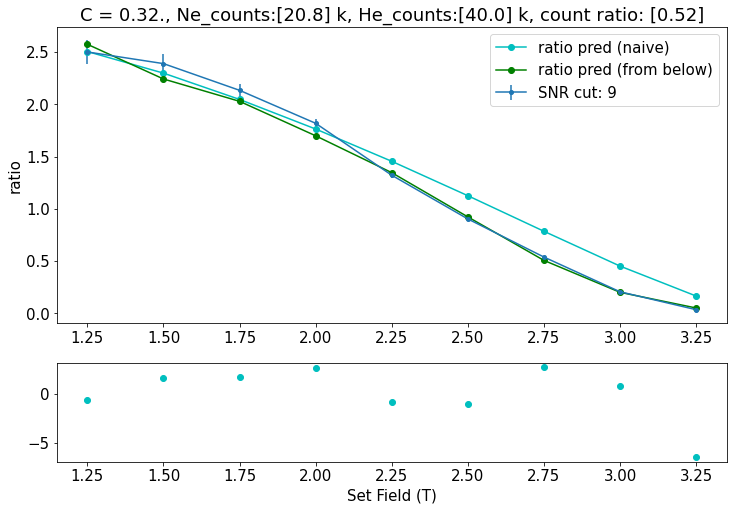

In [84]:
plt.rcParams.update({'font.size': 15})
f, (ax0, ax1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]},figsize=(12,8))

ne_counts = []
he_counts = []

slew_free = True
for cut in snr_cuts: 
    
    const_scaling = np.array([1,1,1,1,1,1,1,1,1,1,1])
    snr_study_spectra["ne"][cut].event_count = snr_study_spectra["ne"][cut].event_count*const_scaling
    snr_study_spectra["he"][cut].event_count = snr_study_spectra["he"][cut].event_count*const_scaling
    print(snr_study_spectra["ne"][cut])
    print(snr_study_spectra["he"][cut])
    # ratio_exp.He6 = ratio_exp.He6*const_scaling
    ratio_exp = re.build_ratio_altnorm(snr_study_spectra["ne"][cut], snr_study_spectra["he"][cut])
    freq_BW = np.array([18.0e9 ,  19.1e9])

    freq_BWs = np.tile(freq_BW, (len(set_fields), 1))

    ratio_pred_naive = rp.AUC_expectation(set_fields, freq_BWs, b = 0, plot = False)

    ratio_exp = ratio_exp[ratio_exp.index.isin(set_fields)]
    
    
#     ratio_exp.Ne19 = ratio_exp.Ne19*const_scaling
#     ratio_exp.He6 = ratio_exp.He6*const_scaling
    print(ratio_exp.sRatio/ratio_exp.Ratio)
    # Fit to the free normalization parameter. 


    my_pars = Parameters()
    my_pars.add('C', value=0.32322636, min=.3, max = .4, vary =True)
    my_pars.add('slew_time', value=.036, min=.03, max = .05, vary =True)
    my_pars.add('b', value=.0, min=-1, max = 1, vary =False)
    result = minimize(objfunc_chisq_slewfree, my_pars, args = (ratio_exp, set_fields,freq_BW ),epsfcn=1e-3, max_nfev = 100)
        # result = minimize(objfunc_chisq_slewfree, my_pars, args = (ratio_exp, set_fields,freq_BW ), max_nfev = 100, method = 'brute',Ns=30)
    # else: result = minimize(objfunc_chisq, my_pars, args = (ratio_pred, ratio_exp))
    
    print(f"reduced chisq: {result.redchi}")
    print(fit_report(result.params))
    C = result.params["C"].value
    b = result.params["b"].value
    slew_time = result.params["slew_time"].value
    
    
    ratio_pred = build_from_below_ratio(set_fields, freq_BW, slew_time, b)
    ratio_exp["Ratio"] = C*ratio_exp["Ratio"]
    ratio_exp["sRatio"] = C*ratio_exp["sRatio"]

    pm.plot_experimental_ratio(ratio_exp, ax0, label= f"SNR cut: {cut}")

    if cut == 9: 
        ax0.plot(ratio_pred_naive.index, ratio_pred_naive.Ratio, color = 'c',
                 label = "ratio pred (naive)",
                marker="o", ms=6,)
        ax0.plot(ratio_pred.index, ratio_pred.Ratio, color = 'g',
                 label = "ratio pred (from below)",
                marker="o", ms=6,)

    ne_counts.append(snr_study_spectra["ne"][cut].event_count.sum().round(-2)/1000)
    he_counts.append(snr_study_spectra["he"][cut].event_count.sum().round(-2)/1000)
    count_ratio = np.array(ne_counts)/np.array(he_counts)

# ax0.set_yscale("log")
ax0.set_ylabel('ratio')
ax1.set_xlabel('Set Field (T)')
ax0.set_title(f"C = {C:.2f}., Ne_counts:{ne_counts} k, He_counts:{he_counts} k, count ratio: {count_ratio}")
ax0.legend()

ax1.plot(ratio_pred.index, (ratio_exp.Ratio - ratio_pred.Ratio)/ratio_exp.sRatio , 
         label= f"snr cut: {cut}", 
         marker="o", 
         ls = "None",
         ms=6, 
         color = "c")
plt.show()